# Quantization of (expected) Persistence Diagram

Théo Lacombe

### Dependencies

This notebook was tested using: 
- `numpy 1.19`
- `scipy 1.5.2`
- `gudhi 3.3`
- `matplotlib 3.3.1`

## Motivation and mathematical formulation

This tutorial present a quantization scheme for persistence diagram as introduced in [this article](https://arxiv.org/pdf/2105.04852.pdf), itself based on ideas presented [here](https://projecteuclid.org/journals/electronic-journal-of-statistics/volume-15/issue-1/Clustering-of-measures-via-mean-measure-quantization/10.1214/21-EJS1834.full). 

Persistence diagrams (see [this tutorial](https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-persistence-diagrams.ipynb) for a detailed presentation) can be described as point clouds supported on a half-plane $\Omega = \{(b,d),\ d>b \} \subset \mathbb{R}^2$. 

In real-life applications, one is likely to have a (large) sequence of **large** diagrams, and it might be of interest to summarize this through a single diagram. 

One approach to do so is to rely on a *Fréchet mean* (a.k.a barycenter, see [that tutorial](https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-Barycenters-of-persistence-diagrams.ipynb)). However, computation of Fréchet means for persistence diagrams is usually intractable on large sets of large diagrams. Furthermore, a Fréchet mean can have large support (much larger than the larger of the observed diagrams), hindering its use in practice. 

To overcome this limitation, we propose in this tutorial to rely on _quantization_: in a nutshell, it consists---given a budget $k$---, of finding a diagram supported on $k$ points that would be a good summary of our observed diagrams. The quality of an approximation should be understood with respect to the [Wasserstein](https://gudhi.inria.fr/python/latest/wasserstein_distance_user.html) or [Bottleneck](https://gudhi.inria.fr/python/latest/bottleneck_distance_user.html) distance between persistence diagrams, respectively denoted by $d_2$ and $d_B$ in the following. 

### Mathematical formulation

More precisely, the theoretical setting is the following one: we assume that our observed persistence diagrams $\mu_1, \dots, \mu_n$ are sampled according to a *distribution* of persistence diagrams $\zeta$, which admits an **expected persistence diagram (EPD)** $\mathbf{ED}(\zeta)$; see [this tutorial](https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-Expected-persistence-diagrams.ipynb) for a more detailed presentation). It is a measure (roughly speaking, a distribution of mass) supported on $\Omega$, though it does not have a discrete support. It can be approximated by its empirical counterpart, namely

$$ \hat{\zeta}_n := \frac{1}{n} \sum_{i=1}^n \mu_i \xrightarrow{n \to \infty} \mathbf{ED}(\zeta), $$

where here, the diagrams $(\mu_i)_i$ should be understood as discrete measures (sum of Dirac masses). In a nutshell, it just consists of a concatenation of the observed diagrams. 


Our goal is to find a set of $k$-points $\mathbf{c} = \{c_1,\dots,c_k\} \subset \Omega$, called a *codebook* whose elements are called *centroids*, along with masses $\mathbf{m} := (m_1,\dots,m_k) \in \mathbb{R}_+^k$, such that the measure $\mu(\mathbf{c}, \mathbf{m}) := \sum_{j=1}^k m_j \delta_{c_j}$ is a good approximation of $\mathbf{ED}(\zeta)$, that is we want to minimize

$$ (\mathbf{c},\mathbf{m}) \mapsto d_{2,B} \left( \sum_{j=1}^k m_j c_j , \mathbf{ED}(\zeta) \right) .$$ 

One can check that chosing a codebook $\mathbf{c}$ systematically determines the corresponding optimal masses $\mathbf{m}$ in a simple way. The intuition is the following one: given a codebook $\mathbf{c}$ and a measure to be quantized (in our case, $\mathbf{ED}(\zeta)$), we want to be able to transport any point $x$ in the support of our measure to the nearest centroid $c_{j^*}$ **or** to the diagonal $\partial \Omega$ if $x$ is closer to $\partial \Omega$ than any centroid, as imposed by the metrics $d_{2,B}$. 

Thus, a codebook $\mathbf{c} = \{ c_1,\dots,c_k\}$ splits the half-plane $\Omega$ in $k+1$ cells: one for each $(c_j)_{1 \leq j \leq k}$, and a last one that accounts for the pecular role played by $\partial \Omega$. See the illustration below.

In [2]:
import utils.utils_quantization as uq
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# We define a codebook with k=6 centoids
codebook = np.array([[2, 4],
               [-2, 2],
               [0, 2], 
               [0, 5],
               [0, 8],
               [-2, 6]])

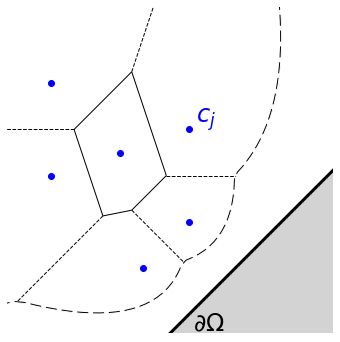

In [4]:
# Visualization of the partition induced by the codebook
uq.plot_partition_codebook(codebook)
# Note: the code of this plot function is not finalized yet and you may come through rendering issues 
# if you change the proposed codebook. 

## The quantization algorithm

As explained above, our goal is actually to optimize the codebook $\mathbf{c}$ (or equivalently, the resulting partition) in order to summarize our collection of observed diagrams. A detailed presentation of the algorithm can be found in the papers referenced above. Loosely speaking, it is an iterative algorithm fairly similar to the Lloyd algorithm used to solve the $k$-means problem (which is a quantization problem as well), with the subtelties that:
- it proceeds in an *online* (or stochastic) fashion, considering batches of observations at each step (in a similar setting, the Lloyd algorithm would consider the concatenation of all diagrams at each step).
- It accounts for the diagonal $\partial \Omega$, which slighly changes the geometry of our problem as it introduces some parabolic-shaped cells (in standard $k$-means, cells are separated by hyperplanes).
- It works with both $d_2$ and $d_B$ metrics; the latter case being handled using ''smallest enclosing circle'' techniques (leveraging the fact that we work in gound dimension $D=2$, making this technique tractable).

It is worth mentioning that one can show, under mild assumptions (see the paper) and provided a good initialization (a standard condition in such algorithms), that this algorithm enjoys $\log(n)/n$ convergence rate towards an optimal codebook in expectation, that is given $n$ observed diagrams,

$$\mathbb{E}(\| \mathbf{c}^{\mathrm{output}} - \mathbf{c}^* \|_2 ) = \mathcal{O}\left(\frac{\log(n)}{n} \right),$$
where $\mathbf{c}^*$ is an optimal codebook (for $\mathbf{ED}(\zeta)$, which is unknown!), and $\mathbf{c}^{\mathrm{output}}$ is the output of our algorithm when going through the sequence of observation.

It is implemented in `./utils/utils_quantization.py`, and a version of it will probably be integrated to Gudhi at some point.

### Experiment overview

We randomly sample $1000$ points in the surface of a torus with some additional noise, leading to a (random) point cloud $\mathbb{X}$, from which we can obtain a (random) persistence diagram $\mu$ accounting for its $1$-dimensional homological features.

We then create $n=100$ realizations of this random process, yielding our sequence of observed diagram $\mu_1,\dots,\mu_n$, and apply our algorithm to it. 

To illustrate the importance of properly accounting for the diagonal $\partial \Omega$, we also showcase what happen if we don't use the $k+1$-th cell to catch points close to the diagonal; referred to as the "vanilla" algorithm.

In [5]:
# Build the dataset, can take few seconds.
n = 100
params = {'nb_points': 1000,
         'r1':5,
         'r2':2,
         'radius_eps':0.1,
         'ambiant_eps':0.1}
Xs, diags = uq.build_dataset(n, params)

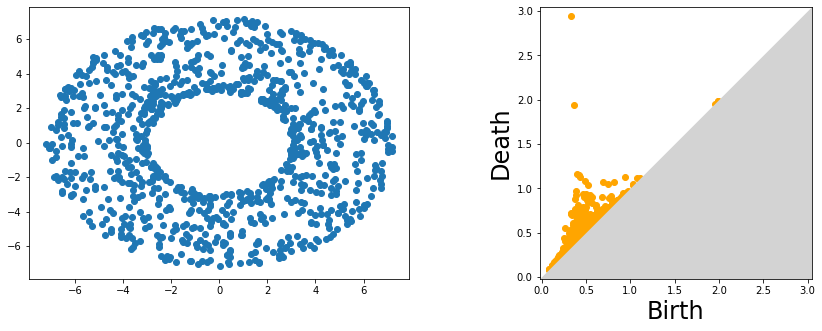

In [6]:
# Short visualization:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(Xs[0][:,0], Xs[0][:,1])  # Plot in 2D for simplicity sake
uq.plot_dgm(diags[0], ax=axs[1], color='orange')

Two points in the diagram (right) stand out: they correspond to the two generative loops of the underlying torus. Points closer to the diagonal play a different role: they account for the fact that we only observe a point cloud and not the torus itself (sampling error). It would be nice to separate these two regimes: that is the role of our $k+1$-th cell.

In [7]:
n = len(diags)
batch_size=10

c0 = np.array([[0.9, 1.8], 
               [1, 2.7]])

order_run = 2.

In [8]:
positions_diag = uq.quantization(diags, batch_size=batch_size, c0=c0, withdiag=True)
positions_vanilla = uq.quantization(diags, batch_size=batch_size, c0=c0, withdiag=False)

c_final_diag = positions_diag[-1]
c_final_vanilla = positions_vanilla[-1]

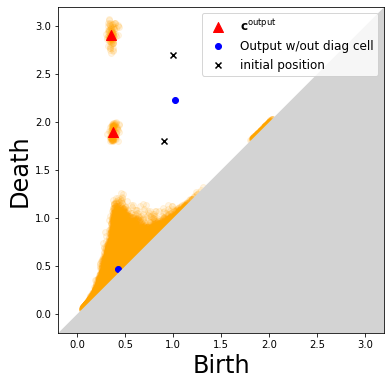

In [9]:
uq.plot_result_quantiz(diags, c_final_diag, c_final_vanilla, c0)

As one can see, our quantization (red triangles) correctly retrieves the two "modes" of the underlying expected persistence diagram $\mathbf{ED}(\zeta)$ (contrary to the "vanilla" codebook whose centroids are "attracted" by points close to the diagonal). Meanwhile, points closer to the diagonal are detected as belonging to the $k+1$-th cell.